In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer

import sklearn.metrics as metrics

# REMEMBER
There are 3 main metrics for model evaluation in regression:
* R Square/Adjusted R Square.
* Mean Square Error(MSE)/Root Mean Square Error(RMSE)
* Mean Absolute Error(MAE)

Along with the standard scoring and cross val score.

In [2]:
def r2adj(model, X, y):
    return 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

## Test Dataset With Converted Object to Float/Int Columns

In [3]:
testdice = pd.read_csv('../created_datasets/test_indice_cols_clean.csv')
testdice.drop(columns = 'Unnamed: 0', inplace = True)
testdice.head()

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,0,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,0.0,9662,Pave,NaN,IR1,Lvl,...,0,0,0,0,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,0,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,0,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,0.0,9500,Pave,NaN,IR1,Lvl,...,0,185,0,0,NaN,NaN,0,7,2009,WD


## Training Dataset With Converted Object to Float/Int Columns

In [4]:
traindice = pd.read_csv('../created_datasets/train_indice_cols_clean.csv')
traindice.drop(columns = 'Unnamed: 0', inplace = True)
traindice.head()

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,SalePrice
0,109,533352170,60,RL,0.0,13517,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,0,3,2010,WD,138500


#### Avoid columns Garage_Yr_Blt

In [5]:
traindice.isnull().sum()

Id              0
PID             0
MS_SubClass     0
MS_Zoning       0
Lot_Frontage    0
               ..
Misc_Val        0
Mo_Sold         0
Yr_Sold         0
Sale_Type       0
SalePrice       0
Length: 81, dtype: int64

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [7]:
pricecorr = traindice.corr()[['SalePrice']].sort_values('SalePrice').iloc[:-1, :]
price_corr = pricecorr.loc[pricecorr['SalePrice'] > 0.5]

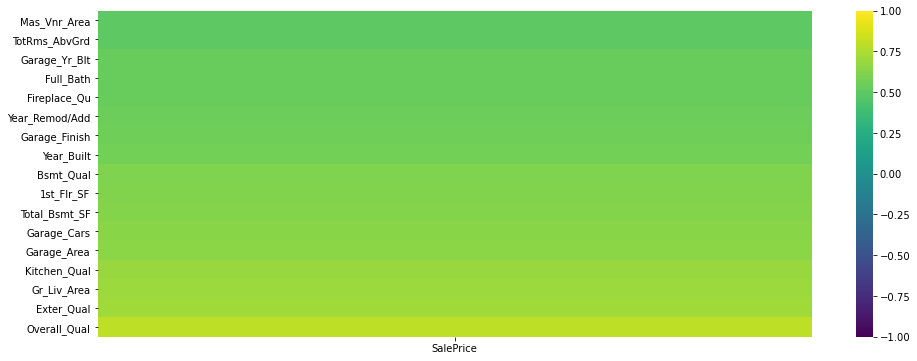

In [8]:
plt.figure(figsize=(16,6))
sns.heatmap(price_corr, cmap = 'viridis', vmin = -1, vmax = 1)
plt.savefig('../graphs/indcolscorr')

In [9]:
pcsort = pricecorr.unstack().sort_values()
#https://www.geeksforgeeks.org/sort-correlation-matrix-in-python/
pcsort

SalePrice  PID               -0.255052
           Enclosed_Porch    -0.135656
           Kitchen_AbvGr     -0.125444
           Overall_Cond      -0.097019
           MS_SubClass       -0.087335
           Id                -0.051398
           Bsmt_Half_Bath    -0.045290
           Low_Qual_Fin_SF   -0.041594
           Yr_Sold           -0.015203
           Misc_Val          -0.007375
           BsmtFin_SF_2       0.016432
           Pool_Area          0.023106
           Pool_QC            0.030585
           Mo_Sold            0.032735
           Exter_Cond         0.036418
           3Ssn_Porch         0.048732
           Screen_Porch       0.134581
           Bedroom_AbvGr      0.137067
           Lot_Frontage       0.181456
           Bsmt_Unf_SF        0.190861
           Bsmt_Cond          0.225075
           2nd_Flr_SF         0.248452
           Garage_Cond        0.265021
           Central_Air        0.277378
           Half_Bath          0.283001
           Bsmt_Full_Bath

# INITIAL FEATURE SELECTION
For this notebook, I will not be accounting for multicollinearity.

In a notebook afterwards, I will be accounting for multicollinearity.

## First feature setting
Using features with coefficients ranging from 0.5-1.0 

In [10]:
features = ['Overall_Qual', 'Exter_Qual', 'Gr_Liv_Area', 'Kitchen_Qual', 'Garage_Area', 'Garage_Cars',
           'Total_Bsmt_SF', '1st_Flr_SF', 'Bsmt_Qual', 'Year_Built', 'Garage_Finish', 'Year_Remod/Add', 'Fireplace_Qu',
           'Full_Bath', 'TotRms_AbvGrd', 'Mas_Vnr_Area']
X = traindice[features]
y = traindice['SalePrice']

In [11]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [12]:
vif_data

,feature,VIF
0,Overall_Qual,70.537466
1,Exter_Qual,103.035529
2,Gr_Liv_Area,50.546873
3,Kitchen_Qual,38.201914
4,Garage_Area,32.950942
5,Garage_Cars,38.443098
6,Total_Bsmt_SF,30.312065
7,1st_Flr_SF,41.543228
8,Bsmt_Qual,43.244029
9,Year_Built,9382.777263


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
X_train.head()

,Overall_Qual,Exter_Qual,Gr_Liv_Area,Kitchen_Qual,Garage_Area,Garage_Cars,Total_Bsmt_SF,1st_Flr_SF,Bsmt_Qual,Year_Built,Garage_Finish,Year_Remod/Add,Fireplace_Qu,Full_Bath,TotRms_AbvGrd,Mas_Vnr_Area
532,6,3,1587,2,525.0,2.0,1587.0,1587,3,1971,1,1971,4,2,7,302.0
415,7,3,2267,2,498.0,2.0,1005.0,1262,3,1937,3,1980,4,1,7,0.0
273,5,3,864,3,720.0,2.0,864.0,864,3,1950,2,2002,0,1,5,0.0
1460,7,4,2260,3,533.0,2.0,1306.0,1306,5,1996,2,1997,0,2,7,0.0
250,8,4,2501,3,751.0,3.0,1242.0,1251,4,1995,2,1995,3,2,9,466.0


### LINEAR REGRESSION MODEL

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
lr.score(X_train, y_train)

0.8061520996713339

In [16]:
lr.score(X_test, y_test)

0.8629596001778268

In [17]:
cross_val_score(lr, X_train, y_train)

array([0.82706964, 0.8155265 , 0.82247937, 0.78581741, 0.66652625])

In [18]:
cross_val_score(lr, X_train, y_train).mean()

0.7834838325061366

In [19]:
cross_val_score(lr, X_test, y_test).mean()

0.8612557707749545

In [20]:
preds = lr.predict(X_train)

(array([ 34., 390., 620., 263., 129.,  51.,  28.,  10.,   6.,   7.]),
 array([ 13100. ,  72955.7, 132811.4, 192667.1, 252522.8, 312378.5,
        372234.2, 432089.9, 491945.6, 551801.3, 611657. ]),
 <BarContainer object of 10 artists>)

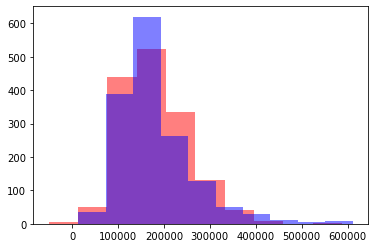

In [21]:
plt.hist(preds, color ='r', alpha=.5)
plt.hist(y_train, color='blue', alpha=.5)

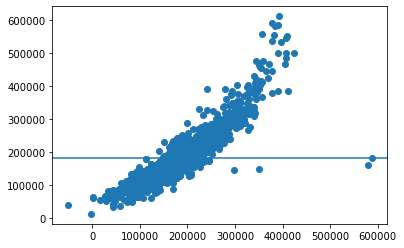

In [22]:
plt.scatter(preds, y_train)
plt.axhline(y_train.mean())

In [23]:
metrics.r2_score(y_train, preds)

0.8061520996713339

In [24]:
r2adj(lr, X_train, y_train)

0.8041129370117293

### PREDICTION OF MODEL AND KAGGLE SUBMISSION

In [25]:
kagglesub1 = testdice
preds =lr.predict(kagglesub1[features])
kagglesub1['SalePrice'] = preds

In [26]:
kagglesub1.head(2)

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,SalePrice
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,0,4,2006,WD,131125.289025
1,2718,905108090,90,RL,0.0,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,0,8,2006,WD,196565.578273


In [27]:
kagglesub1 = kagglesub1[['Id', 'SalePrice']]

In [28]:
kagglesub1.head(2)

,Id,SalePrice
0,2658,131125.289025
1,2718,196565.578273


In [29]:
kagglesub1.to_csv('../kaggle_submissions/kaggle1.csv', index=False)

### DUMMY AND TREE MODELS

In [30]:
dummy = DummyRegressor()

In [31]:
dummy.fit(X_train, y_train)

DummyRegressor()

In [32]:
cross_val_score(dummy, X_train, y_train).mean()

-0.0009377481689546663

In [33]:
dummy.score(X_train, y_train)

0.0

In [34]:
dummy.score(X_test, y_test)

-0.00043273813883448753

In [35]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [36]:
cross_val_score(tree, X_train, y_train).mean()

0.75817819888185

In [37]:
cross_val_score(tree, X_test, y_test).mean()

0.7420661502897168

In [38]:
tree.score(X_train, y_train)

0.999778707113416

In [39]:
tree.score(X_test, y_test)

0.7649699269016584

## Second feature setting
Using features with coefficients ranging from 0.6-1.0

In [40]:
features = ['Overall_Qual', 'Exter_Qual', 'Gr_Liv_Area', 'Kitchen_Qual', 'Garage_Area', 'Garage_Cars',
           'Total_Bsmt_SF', '1st_Flr_SF', 'Bsmt_Qual']
X = traindice[features]
y = traindice['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
X_train.head()

,Overall_Qual,Exter_Qual,Gr_Liv_Area,Kitchen_Qual,Garage_Area,Garage_Cars,Total_Bsmt_SF,1st_Flr_SF,Bsmt_Qual
532,6,3,1587,2,525.0,2.0,1587.0,1587,3
415,7,3,2267,2,498.0,2.0,1005.0,1262,3
273,5,3,864,3,720.0,2.0,864.0,864,3
1460,7,4,2260,3,533.0,2.0,1306.0,1306,5
250,8,4,2501,3,751.0,3.0,1242.0,1251,4


In [41]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [42]:
vif_data

,feature,VIF
0,Overall_Qual,66.728630
1,Exter_Qual,66.678319
2,Gr_Liv_Area,18.445319
3,Kitchen_Qual,36.899708
4,Garage_Area,31.441716
5,Garage_Cars,34.476680
6,Total_Bsmt_SF,26.520709
7,1st_Flr_SF,35.866358
8,Bsmt_Qual,37.104839


#### EXTREME COLLINEARITY BETWEEN VARIABLES

In [43]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
def autocorr(i):
    X1 =np.arange(len(X[[i]]))
    Y = np.asarray(X[[i]])
    ols_res = OLS(Y,X1).fit()
    print(feature)
    print(durbin_watson(ols_res.resid))
for feature in features:
    autocorr(feature)

Overall_Qual
0.3580963968717398
Exter_Qual
0.21722326363443117
Gr_Liv_Area
0.6375733928443406
Kitchen_Qual
0.43408791930808005
Garage_Area
0.9142675161160231
Garage_Cars
0.8614584376805808
Total_Bsmt_SF
0.8650431303159756
1st_Flr_SF
0.6473633962677195
Bsmt_Qual
0.4382393183718829


#### EXTREME AUTOCORRELATION

### LINEAR REGRESSION MODEL

In [44]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [45]:
lr.score(X_train, y_train)

0.7931968977344549

In [46]:
lr.score(X_test, y_test)

0.8524222816213304

In [47]:
cross_val_score(lr, X_train, y_train)

array([0.82113432, 0.81931812, 0.81235442, 0.76883986, 0.66230248])

In [48]:
cross_val_score(lr, X_train, y_train).mean()

0.7767898401502137

In [49]:
preds = lr.predict(X_train)

In [50]:
metrics.r2_score(y_train, preds)

0.7931968977344549

In [51]:
metrics.mean_squared_error(y_train, preds)

1307930403.2315335

In [52]:
metrics.mean_squared_error(y_train, preds, squared=False)

36165.320449728264

In [53]:
metrics.mean_absolute_error(y_train, preds)

23232.75756459273

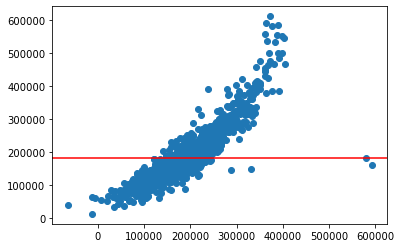

In [54]:
plt.scatter(x=preds, y=y_train)
plt.axhline(y_train.mean(), color ='r')

(array([  5.,  37., 160., 141.,  72.,  39.,  24.,  15.,  10.,  10.]),
 array([ 12789. ,  57510.1, 102231.2, 146952.3, 191673.4, 236394.5,
        281115.6, 325836.7, 370557.8, 415278.9, 460000. ]),
 <BarContainer object of 10 artists>)

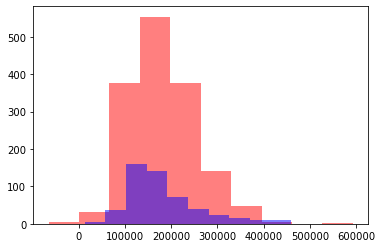

In [55]:
plt.hist(preds, color='r', alpha=.5)
plt.hist(y_test, color = 'blue', alpha=.5)

### KAGGLE SUB 2

In [56]:
kagglesub2 = testdice
preds =lr.predict(kagglesub2[features])
kagglesub2['SalePrice'] = preds

In [57]:
kagglesub2.head(2)

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,SalePrice
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,0,4,2006,WD,140412.047595
1,2718,905108090,90,RL,0.0,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,0,8,2006,WD,202089.553641


In [58]:
kagglesub2 = kagglesub2[['Id', 'SalePrice']]

In [59]:
kagglesub2.head(2)

,Id,SalePrice
0,2658,140412.047595
1,2718,202089.553641


In [60]:
kagglesub2.to_csv('../kaggle_submissions/kaggle2.csv', index=False)

## POLYNOMIAL CREATION

In [61]:
poly = PolynomialFeatures(include_bias = False)
poly.fit(X)

PolynomialFeatures(include_bias=False)

In [62]:
X_poly = poly.transform(X)
X_poly

array([[6.000000e+00, 4.000000e+00, 1.479000e+03, ..., 5.256250e+05,
        2.175000e+03, 9.000000e+00],
       [7.000000e+00, 4.000000e+00, 2.122000e+03, ..., 8.335690e+05,
        3.652000e+03, 1.600000e+01],
       [5.000000e+00, 3.000000e+00, 1.057000e+03, ..., 1.117249e+06,
        3.171000e+03, 9.000000e+00],
       ...,
       [6.000000e+00, 3.000000e+00, 1.913000e+03, ..., 1.373584e+06,
        3.516000e+03, 9.000000e+00],
       [4.000000e+00, 3.000000e+00, 1.200000e+03, ..., 1.440000e+06,
        3.600000e+03, 9.000000e+00],
       [7.000000e+00, 3.000000e+00, 1.804000e+03, ..., 1.056784e+06,
        3.084000e+03, 9.000000e+00]])

In [63]:
features = poly.get_feature_names(features)
features

['Overall_Qual',
 'Exter_Qual',
 'Gr_Liv_Area',
 'Kitchen_Qual',
 'Garage_Area',
 'Garage_Cars',
 'Total_Bsmt_SF',
 '1st_Flr_SF',
 'Bsmt_Qual',
 'Overall_Qual^2',
 'Overall_Qual Exter_Qual',
 'Overall_Qual Gr_Liv_Area',
 'Overall_Qual Kitchen_Qual',
 'Overall_Qual Garage_Area',
 'Overall_Qual Garage_Cars',
 'Overall_Qual Total_Bsmt_SF',
 'Overall_Qual 1st_Flr_SF',
 'Overall_Qual Bsmt_Qual',
 'Exter_Qual^2',
 'Exter_Qual Gr_Liv_Area',
 'Exter_Qual Kitchen_Qual',
 'Exter_Qual Garage_Area',
 'Exter_Qual Garage_Cars',
 'Exter_Qual Total_Bsmt_SF',
 'Exter_Qual 1st_Flr_SF',
 'Exter_Qual Bsmt_Qual',
 'Gr_Liv_Area^2',
 'Gr_Liv_Area Kitchen_Qual',
 'Gr_Liv_Area Garage_Area',
 'Gr_Liv_Area Garage_Cars',
 'Gr_Liv_Area Total_Bsmt_SF',
 'Gr_Liv_Area 1st_Flr_SF',
 'Gr_Liv_Area Bsmt_Qual',
 'Kitchen_Qual^2',
 'Kitchen_Qual Garage_Area',
 'Kitchen_Qual Garage_Cars',
 'Kitchen_Qual Total_Bsmt_SF',
 'Kitchen_Qual 1st_Flr_SF',
 'Kitchen_Qual Bsmt_Qual',
 'Garage_Area^2',
 'Garage_Area Garage_Cars',
 'Gar

In [64]:
cross_val_score(lr,X_poly, y).mean()

0.8611448536081833

In [65]:
cross_val_score(lr,X_poly, y).mean()

0.8611448536081833

In [66]:
poly2df = pd.DataFrame(X_poly, columns = features)
poly2df

,Overall_Qual,Exter_Qual,Gr_Liv_Area,Kitchen_Qual,Garage_Area,Garage_Cars,Total_Bsmt_SF,1st_Flr_SF,Bsmt_Qual,Overall_Qual^2,...,Garage_Cars^2,Garage_Cars Total_Bsmt_SF,Garage_Cars 1st_Flr_SF,Garage_Cars Bsmt_Qual,Total_Bsmt_SF^2,Total_Bsmt_SF 1st_Flr_SF,Total_Bsmt_SF Bsmt_Qual,1st_Flr_SF^2,1st_Flr_SF Bsmt_Qual,Bsmt_Qual^2
0,6.0,4.0,1479.0,3.0,475.0,2.0,725.0,725.0,3.0,36.0,...,4.0,1450.0,1450.0,6.0,525625.0,525625.0,2175.0,525625.0,2175.0,9.0
1,7.0,4.0,2122.0,3.0,559.0,2.0,913.0,913.0,4.0,49.0,...,4.0,1826.0,1826.0,8.0,833569.0,833569.0,3652.0,833569.0,3652.0,16.0
2,5.0,3.0,1057.0,3.0,246.0,1.0,1057.0,1057.0,3.0,25.0,...,1.0,1057.0,1057.0,3.0,1117249.0,1117249.0,3171.0,1117249.0,3171.0,9.0
3,5.0,3.0,1444.0,2.0,400.0,2.0,384.0,744.0,4.0,25.0,...,4.0,768.0,1488.0,8.0,147456.0,285696.0,1536.0,553536.0,2976.0,16.0
4,6.0,3.0,1445.0,2.0,484.0,2.0,676.0,831.0,2.0,36.0,...,4.0,1352.0,1662.0,4.0,456976.0,561756.0,1352.0,690561.0,1662.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,8.0,4.0,1728.0,3.0,520.0,2.0,1884.0,1728.0,4.0,64.0,...,4.0,3768.0,3456.0,8.0,3549456.0,3255552.0,7536.0,2985984.0,6912.0,16.0
2047,4.0,3.0,861.0,2.0,539.0,2.0,861.0,861.0,3.0,16.0,...,4.0,1722.0,1722.0,6.0,741321.0,741321.0,2583.0,741321.0,2583.0,9.0
2048,6.0,3.0,1913.0,2.0,342.0,2.0,896.0,1172.0,3.0,36.0,...,4.0,1792.0,2344.0,6.0,802816.0,1050112.0,2688.0,1373584.0,3516.0,9.0
2049,4.0,3.0,1200.0,2.0,294.0,1.0,1200.0,1200.0,3.0,16.0,...,1.0,1200.0,1200.0,3.0,1440000.0,1440000.0,3600.0,1440000.0,3600.0,9.0


In [67]:
poly2df['SalePrice'] = traindice['SalePrice']

polycorr = poly2df.corr()[['SalePrice']].sort_values('SalePrice').iloc[:-1, :]
polycorr

,SalePrice
Total_Bsmt_SF^2,0.497716
1st_Flr_SF^2,0.529102
Total_Bsmt_SF 1st_Flr_SF,0.539701
Bsmt_Qual,0.612188
1st_Flr_SF,0.618486
Gr_Liv_Area Total_Bsmt_SF,0.624888
Gr_Liv_Area 1st_Flr_SF,0.629107
Total_Bsmt_SF,0.629303
Gr_Liv_Area^2,0.629686
Garage_Area^2,0.642760


In [68]:
X = poly2df[features]
y = poly2df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
X_train.head()

,Overall_Qual,Exter_Qual,Gr_Liv_Area,Kitchen_Qual,Garage_Area,Garage_Cars,Total_Bsmt_SF,1st_Flr_SF,Bsmt_Qual,Overall_Qual^2,...,Garage_Cars^2,Garage_Cars Total_Bsmt_SF,Garage_Cars 1st_Flr_SF,Garage_Cars Bsmt_Qual,Total_Bsmt_SF^2,Total_Bsmt_SF 1st_Flr_SF,Total_Bsmt_SF Bsmt_Qual,1st_Flr_SF^2,1st_Flr_SF Bsmt_Qual,Bsmt_Qual^2
532,6.0,3.0,1587.0,2.0,525.0,2.0,1587.0,1587.0,3.0,36.0,...,4.0,3174.0,3174.0,6.0,2518569.0,2518569.0,4761.0,2518569.0,4761.0,9.0
415,7.0,3.0,2267.0,2.0,498.0,2.0,1005.0,1262.0,3.0,49.0,...,4.0,2010.0,2524.0,6.0,1010025.0,1268310.0,3015.0,1592644.0,3786.0,9.0
273,5.0,3.0,864.0,3.0,720.0,2.0,864.0,864.0,3.0,25.0,...,4.0,1728.0,1728.0,6.0,746496.0,746496.0,2592.0,746496.0,2592.0,9.0
1460,7.0,4.0,2260.0,3.0,533.0,2.0,1306.0,1306.0,5.0,49.0,...,4.0,2612.0,2612.0,10.0,1705636.0,1705636.0,6530.0,1705636.0,6530.0,25.0
250,8.0,4.0,2501.0,3.0,751.0,3.0,1242.0,1251.0,4.0,64.0,...,9.0,3726.0,3753.0,12.0,1542564.0,1553742.0,4968.0,1565001.0,5004.0,16.0


In [69]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [70]:
cross_val_score(lr, X_train, y_train).mean()

0.8480364062502934

In [71]:
cross_val_score(lr, X_test, y_test).mean()

0.8629324361064985

In [72]:
lr.score(X_train, y_train)

0.886750361242026

In [73]:
lr.score(X_test, y_test)

0.8783147239315748

In [74]:
preds = lr.predict(X_train)

In [75]:
metrics.r2_score(y_train, preds)

0.886750361242026

In [76]:
metrics.mean_squared_error(y_train, preds)

716249630.996086

In [77]:
metrics.mean_squared_error(y_train, preds, squared=False)

26762.840488185964

In [78]:
r2adj(lr, X_train, y_train)

0.8826266387248779

In [79]:
metrics.mean_absolute_error(y_train, preds)

18914.484052203057

In [80]:
preds = lr.predict(X_test)

In [81]:
metrics.r2_score(y_test, preds)

0.8783147239315748

In [82]:
residuals = y_test - preds

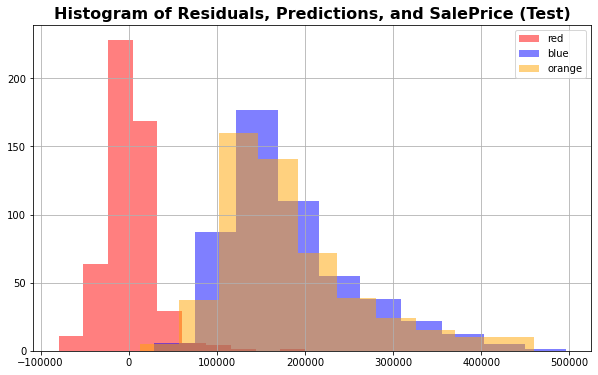

In [86]:
plt.figure(figsize=(10,6))
residuals.hist(color='r', alpha=.5)
plt.hist(x = preds, color='blue', alpha=.5)
plt.hist(x = y_test, color='orange', alpha=.5)
plt.legend(['red', 'blue', 'orange'])
plt.title('Histogram of Residuals, Predictions, and SalePrice (Test)', fontsize = 16, fontweight = 'bold')
plt.savefig('../graphs/hist_kagglemod', bbox_inches = 'tight')

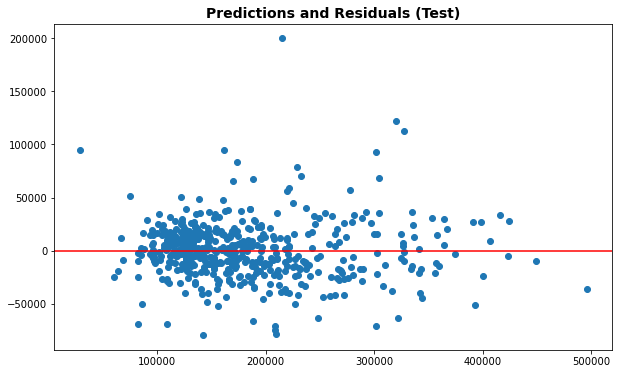

In [87]:
plt.figure(figsize=(10,6))
plt.scatter(x=preds, y=residuals)
plt.title('Predictions and Residuals (Test)', fontsize = 14, fontweight = 'bold')
plt.axhline(0,color='r')
plt.savefig('../graphs/preds_residuals_test_kagglemod', bbox_inches = 'tight')

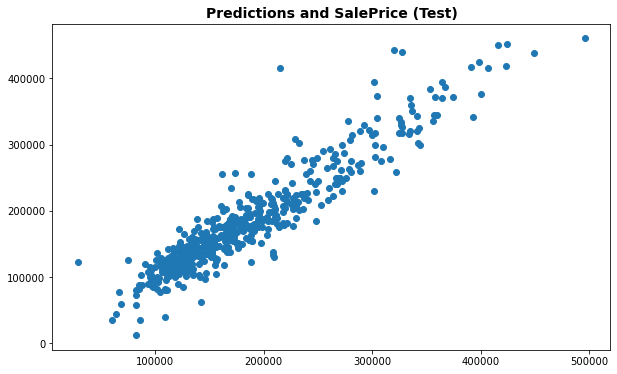

In [88]:
plt.figure(figsize=(10,6))
plt.scatter(x=preds, y=y_test)
plt.title('Predictions and SalePrice (Test)', fontsize = 14, fontweight = 'bold')
plt.savefig('../graphs/preds_saleprice_test_kagglemod', bbox_inches='tight')

(array([  5.,  37., 160., 141.,  72.,  39.,  24.,  15.,  10.,  10.]),
 array([ 12789. ,  57510.1, 102231.2, 146952.3, 191673.4, 236394.5,
        281115.6, 325836.7, 370557.8, 415278.9, 460000. ]),
 <BarContainer object of 10 artists>)

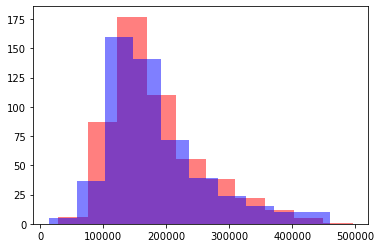

In [226]:
plt.hist(preds, color='r', alpha=.5)
plt.hist(y_test, color = 'blue', alpha=.5)

## KAGGLE SUBMISSION

In [227]:
features = ['Overall_Qual', 'Exter_Qual', 'Gr_Liv_Area', 'Kitchen_Qual', 'Garage_Area', 'Garage_Cars',
           'Total_Bsmt_SF', '1st_Flr_SF', 'Bsmt_Qual']
X = testdice[features]

poly = PolynomialFeatures(include_bias = False)
poly.fit(X)

X_poly = poly.transform(X)
X_poly

features = poly.get_feature_names(features)

polykg2df = pd.DataFrame(X_poly, columns = features)

polykg2df['ID'] = testdice['Id']

X = polykg2df[features]



preds = lr.predict(X)
polykg2df['SalePrice'] = preds

In [228]:
polykg2df.head(2)

,Overall_Qual,Exter_Qual,Gr_Liv_Area,Kitchen_Qual,Garage_Area,Garage_Cars,Total_Bsmt_SF,1st_Flr_SF,Bsmt_Qual,Overall_Qual^2,...,Garage_Cars 1st_Flr_SF,Garage_Cars Bsmt_Qual,Total_Bsmt_SF^2,Total_Bsmt_SF 1st_Flr_SF,Total_Bsmt_SF Bsmt_Qual,1st_Flr_SF^2,1st_Flr_SF Bsmt_Qual,Bsmt_Qual^2,ID,SalePrice
0,6.0,3.0,1928.0,1.0,440.0,1.0,1020.0,908.0,2.0,36.0,...,908.0,2.0,1040400.0,926160.0,2040.0,824464.0,1816.0,4.0,2658,142320.669958
1,5.0,3.0,1967.0,2.0,580.0,2.0,1967.0,1967.0,4.0,25.0,...,3934.0,8.0,3869089.0,3869089.0,7868.0,3869089.0,7868.0,16.0,2718,171394.000513


In [229]:
polykg2df = polykg2df[['ID', 'SalePrice']]

In [230]:
kagglesub1.head(2)

,Id,SalePrice
0,2658,131125.289025
1,2718,196565.578273


In [231]:
polykg2df.to_csv('../kaggle_submissions/kagglepoly1.csv', index=False)

## CREATION OF LASSO AND RIDGE MODELS

#### SCALING THE DATA FIRST PRIOR TO RIDGE USE

In [232]:
sc = StandardScaler()
sc.fit(X_train)
Z_train = sc.transform(X_train)
Z_test = sc.transform(X_test)

In [233]:
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test.shape}')

Z_train shape is: (1538, 54)
y_train shape is: (1538,)
Z_test shape is: (513, 54)
y_test shape is: (513,)


In [234]:
ols = LinearRegression()
ols.fit(Z_train, y_train)

LinearRegression()

In [235]:
ols.score(Z_train, y_train), ols.score(Z_test, y_test)

(0.886750361242026, 0.8783147239536746)

In [236]:
(ols.coef_ ** 2).sum()

35384530830.4194

### RIDGE USE

In [237]:
# Instantiate.
ridge = Ridge(alpha=16.0)
# Fit.
ridge.fit(Z_train, y_train)
# Evaluate model using R2.
ridge.score(Z_train, y_train), ridge.score(Z_test, y_test)

(0.8807049114239573, 0.8920914767852388)

In [238]:
# Set up a list of ridge alphas to check.
# np.logspace generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.
alphas = np.logspace(0, 5, 100)
# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train);

In [239]:
ridge_cv.alpha_

14.508287784959395

In [240]:
ridge_cv.best_score_

0.8625972919511259

In [241]:
ridge_cv.score(Z_train, y_train), ridge_cv.score(Z_test, y_test)

(0.8810505145499433, 0.8919640149147664)

In [242]:
ols.score(Z_train, y_train), ols.score(Z_test, y_test)

(0.886750361242026, 0.8783147239536746)

### LASSO

In [243]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)
lasso = LassoCV(alphas=l_alphas, cv=5)
# Cross-validate over our list of Lasso alphas.
lasso.fit(Z_train, y_train)
# Fit model using best ridge alpha!

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425707459496.258, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 417148517694.06354, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406208382845.34326, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/py

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11261178077.80835, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11264866724.649902, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11266754266.248413, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/p

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11247485196.927002, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11247383842.59668, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11247325474.93457, tolerance: 778133067.1215106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/py

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16878491180.964722, tolerance: 803375304.0487227
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9769935586.649414, tolerance: 803375304.0487227
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14133660174.64795, tolerance: 803375304.0487227
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/py

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11301650769.578613, tolerance: 803375304.0487227
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11301080539.791748, tolerance: 803375304.0487227
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11300690409.462158, tolerance: 803375304.0487227
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303256523066.87744, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288480321629.0743, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288422478213.5763, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/py

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8335209987.09436, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8351343175.0373535, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8357736316.309326, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/pyt

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8336558560.697998, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8336894830.516846, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8336574871.570068, tolerance: 760708549.4053607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/pyt

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22634995246.674683, tolerance: 731633840.9885501
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22635059566.02771, tolerance: 731633840.9885501
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22639508089.09192, tolerance: 731633840.9885501
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/py

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22619709126.94043, tolerance: 731633840.9885501
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22619530475.15918, tolerance: 731633840.9885501
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22619420824.771973, tolerance: 731633840.9885501
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/py

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92389319012.82202, tolerance: 816865125.5190994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43129935444.98511, tolerance: 816865125.5190994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55002700247.01575, tolerance: 816865125.5190994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/pyt

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17121806365.696533, tolerance: 816865125.5190994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17121410170.96753, tolerance: 816865125.5190994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17121061062.294434, tolerance: 816865125.5190994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/p

/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17115911590.82788, tolerance: 816865125.5190994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/adamklesc11/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 528465632100.1876, tolerance: 972711210.8729936
  model = cd_fast.enet_coordinate_descent(


LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        cv=5)

In [244]:
lasso.alpha_

1.0

In [245]:
l_alphas[[0, -1]]

array([0.001, 1.   ])

In [246]:
lasso.score(Z_train, y_train), lasso.score(Z_test, y_test)


(0.8858975650513014, 0.8821231022794424)

In [247]:
ridge_cv.coef_

array([ -1200.15671077,  -7961.88364813,  -8626.04447131,  -7978.97080634,
        -5497.5428375 ,  -7773.56123469,   2478.53340436,   5094.30741273,
        -5368.28913373,  -3343.06559042,    642.51848974,  22696.76166244,
        -1333.50849202,   4350.79277696,   3033.05132556,  16546.71041658,
        11084.39991003,  -2033.25399561,   3291.67777042,  13684.50540734,
        -1541.62047596,   6341.27286549,    335.64975077,   8320.85129232,
         6775.38932113,  -1866.23129174,  -5300.05490107,  21017.21321949,
        -5939.70854503,  13875.53708333, -11046.29388279, -12429.31916585,
        11003.55802345,   2627.25773986,   6938.01902469,   2126.1532576 ,
         2648.29507101,   8835.34931043,  -7556.13163068,   4860.79611677,
        -1600.8717609 ,  -7600.35305759,  -4894.74859218,   4022.26252281,
       -10182.90946706,   8791.40896144,   9893.23166505,    793.54819607,
       -11449.83040817, -21824.31930501,  18044.52674082,  -8954.86934684,
        -2608.78943987,  

In [248]:
lasso.coef_

array([  3879.30642719, -18404.26836312, -21552.98602162,  -7852.24757021,
       -17321.75607464,   4317.41460533, -15563.44392045,  18110.16934214,
         7186.2694566 , -47740.6018974 ,  39240.56679345,  72856.10726277,
       -12760.67932128,  -2556.24077889,   6781.91306336,  55013.53557518,
        -7650.13631501, -11806.26228731,  12941.25268924,   1505.64110016,
       -19161.87186225,  20807.87404034, -18030.19977497,  -3709.09334715,
        10254.12437883,  -2167.50747362,  -9866.54410068,  31156.70933455,
       -23067.7178168 ,  25201.55799256,   7882.80044131, -47838.80453293,
         7719.48211263,  11363.60134648,  17182.13310134,  -5822.24101953,
       -15950.13220461,  20112.64196481,   -178.24277079,  18785.39503199,
        -3579.80748419, -26580.6161015 ,  -2561.20171766,   6422.48899425,
       -20996.37049316,  11453.78233225,  17995.78654264,   8210.67241643,
        -1664.6939479 , -35987.84543917,  36841.53389515,   5668.21010835,
       -13975.97827327,  

In [249]:
features = ['Overall_Qual', 'Exter_Qual', 'Gr_Liv_Area', 'Kitchen_Qual', 'Garage_Area', 'Garage_Cars',
           'Total_Bsmt_SF', '1st_Flr_SF', 'Bsmt_Qual']
X = traindice[features]

In [250]:
lasso_coefs = pd.Series(lasso.coef_, index=poly.get_feature_names(X.columns))
lasso_coefs

Overall_Qual                   3879.306427
Exter_Qual                   -18404.268363
Gr_Liv_Area                  -21552.986022
Kitchen_Qual                  -7852.247570
Garage_Area                  -17321.756075
Garage_Cars                    4317.414605
Total_Bsmt_SF                -15563.443920
1st_Flr_SF                    18110.169342
Bsmt_Qual                      7186.269457
Overall_Qual^2               -47740.601897
Overall_Qual Exter_Qual       39240.566793
Overall_Qual Gr_Liv_Area      72856.107263
Overall_Qual Kitchen_Qual    -12760.679321
Overall_Qual Garage_Area      -2556.240779
Overall_Qual Garage_Cars       6781.913063
Overall_Qual Total_Bsmt_SF    55013.535575
Overall_Qual 1st_Flr_SF       -7650.136315
Overall_Qual Bsmt_Qual       -11806.262287
Exter_Qual^2                  12941.252689
Exter_Qual Gr_Liv_Area         1505.641100
Exter_Qual Kitchen_Qual      -19161.871862
Exter_Qual Garage_Area        20807.874040
Exter_Qual Garage_Cars       -18030.199775
Exter_Qual 

<AxesSubplot:>

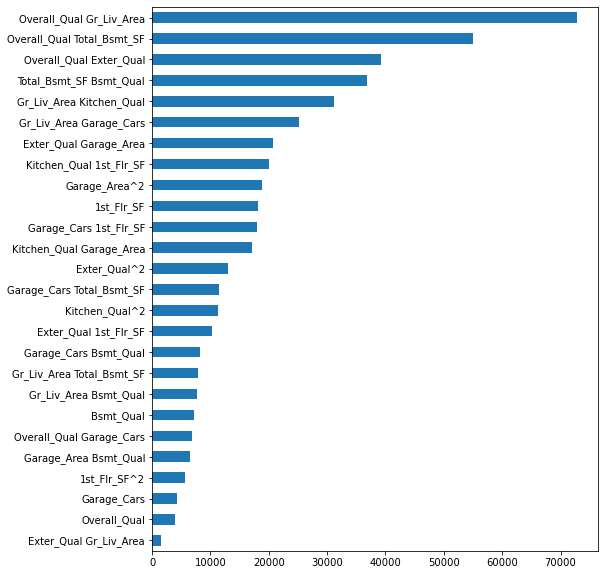

In [251]:
plt.figure(figsize=(8, 10))
lasso_coefs[lasso_coefs > 0].sort_values().plot.barh()

<AxesSubplot:>

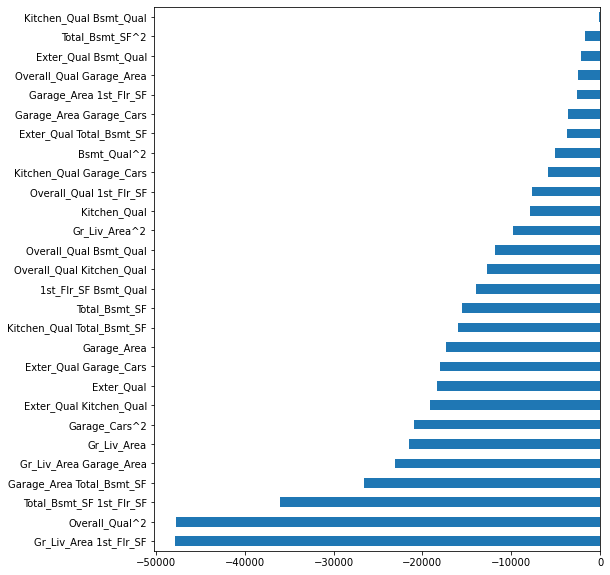

In [252]:
plt.figure(figsize=(8, 10))
lasso_coefs[lasso_coefs < 0].sort_values().plot.barh()

In [253]:
lasso_coefs[lasso_coefs < 0].sort_values().mean()

-14981.212745638066

In [254]:
len(lasso_coefs[lasso_coefs < 0].sort_values())

28

In [255]:
lasso_coefs[lasso_coefs < 0].sum()

-419473.95687786577

In [256]:
len(lasso_coefs[lasso_coefs > 0].sort_values())

26

In [257]:
lasso_coefs[lasso_coefs > 0].sum()

478890.9703493267

In [258]:
lasso_coefs.mean()

1100.315064286312

In [259]:
lasso_coefs[lasso_coefs < -14981.212745638066].sort_values()

Gr_Liv_Area 1st_Flr_SF       -47838.804533
Overall_Qual^2               -47740.601897
Total_Bsmt_SF 1st_Flr_SF     -35987.845439
Garage_Area Total_Bsmt_SF    -26580.616101
Gr_Liv_Area Garage_Area      -23067.717817
Gr_Liv_Area                  -21552.986022
Garage_Cars^2                -20996.370493
Exter_Qual Kitchen_Qual      -19161.871862
Exter_Qual                   -18404.268363
Exter_Qual Garage_Cars       -18030.199775
Garage_Area                  -17321.756075
Kitchen_Qual Total_Bsmt_SF   -15950.132205
Total_Bsmt_SF                -15563.443920
dtype: float64

In [260]:
lasso_coefs[lasso_coefs > 0].sort_values().mean()

18418.8834749741

In [261]:
lasso_coefs[lasso_coefs > 18418.8834749741].sort_values()

Garage_Area^2                 18785.395032
Kitchen_Qual 1st_Flr_SF       20112.641965
Exter_Qual Garage_Area        20807.874040
Gr_Liv_Area Garage_Cars       25201.557993
Gr_Liv_Area Kitchen_Qual      31156.709335
Total_Bsmt_SF Bsmt_Qual       36841.533895
Overall_Qual Exter_Qual       39240.566793
Overall_Qual Total_Bsmt_SF    55013.535575
Overall_Qual Gr_Liv_Area      72856.107263
dtype: float64

In [262]:
lasso_coefs[lasso_coefs > 0].sort_values(ascending=False)

Overall_Qual Gr_Liv_Area      72856.107263
Overall_Qual Total_Bsmt_SF    55013.535575
Overall_Qual Exter_Qual       39240.566793
Total_Bsmt_SF Bsmt_Qual       36841.533895
Gr_Liv_Area Kitchen_Qual      31156.709335
Gr_Liv_Area Garage_Cars       25201.557993
Exter_Qual Garage_Area        20807.874040
Kitchen_Qual 1st_Flr_SF       20112.641965
Garage_Area^2                 18785.395032
1st_Flr_SF                    18110.169342
Garage_Cars 1st_Flr_SF        17995.786543
Kitchen_Qual Garage_Area      17182.133101
Exter_Qual^2                  12941.252689
Garage_Cars Total_Bsmt_SF     11453.782332
Kitchen_Qual^2                11363.601346
Exter_Qual 1st_Flr_SF         10254.124379
Garage_Cars Bsmt_Qual          8210.672416
Gr_Liv_Area Total_Bsmt_SF      7882.800441
Gr_Liv_Area Bsmt_Qual          7719.482113
Bsmt_Qual                      7186.269457
Overall_Qual Garage_Cars       6781.913063
Garage_Area Bsmt_Qual          6422.488994
1st_Flr_SF^2                   5668.210108
Garage_Cars

CONSIDERING 

CREATION OF LIST OF VALUES FOR LATER

In [263]:
polycorr7 = polycorr.loc[polycorr['SalePrice'] > 0.7]
polycorr7

,SalePrice
Garage_Area 1st_Flr_SF,0.705365
Kitchen_Qual^2,0.708433
Exter_Qual,0.712146
Exter_Qual^2,0.721290
Exter_Qual Total_Bsmt_SF,0.735545
Total_Bsmt_SF Bsmt_Qual,0.742991
Exter_Qual 1st_Flr_SF,0.753101
Gr_Liv_Area Garage_Area,0.754659
Exter_Qual Bsmt_Qual,0.755313
Kitchen_Qual Total_Bsmt_SF,0.759551


In [264]:
pcsort = polycorr7.unstack().sort_values()
pcsort

SalePrice  Garage_Area 1st_Flr_SF        0.705365
           Kitchen_Qual^2                0.708433
           Exter_Qual                    0.712146
           Exter_Qual^2                  0.721290
           Exter_Qual Total_Bsmt_SF      0.735545
           Total_Bsmt_SF Bsmt_Qual       0.742991
           Exter_Qual 1st_Flr_SF         0.753101
           Gr_Liv_Area Garage_Area       0.754659
           Exter_Qual Bsmt_Qual          0.755313
           Kitchen_Qual Total_Bsmt_SF    0.759551
           Garage_Cars 1st_Flr_SF        0.760121
           1st_Flr_SF Bsmt_Qual          0.760798
           Exter_Qual Kitchen_Qual       0.766494
           Kitchen_Qual 1st_Flr_SF       0.767139
           Garage_Cars Total_Bsmt_SF     0.767335
           Overall_Qual Total_Bsmt_SF    0.768630
           Exter_Qual Garage_Area        0.769923
           Garage_Cars Bsmt_Qual         0.770014
           Kitchen_Qual Bsmt_Qual        0.775066
           Garage_Area Bsmt_Qual         0.775321


In [265]:
keylist7 =[]
for n in pcsort.items():
    keylist7.append(n[0][1])
print(keylist7)

['Garage_Area 1st_Flr_SF', 'Kitchen_Qual^2', 'Exter_Qual', 'Exter_Qual^2', 'Exter_Qual Total_Bsmt_SF', 'Total_Bsmt_SF Bsmt_Qual', 'Exter_Qual 1st_Flr_SF', 'Gr_Liv_Area Garage_Area', 'Exter_Qual Bsmt_Qual', 'Kitchen_Qual Total_Bsmt_SF', 'Garage_Cars 1st_Flr_SF', '1st_Flr_SF Bsmt_Qual', 'Exter_Qual Kitchen_Qual', 'Kitchen_Qual 1st_Flr_SF', 'Garage_Cars Total_Bsmt_SF', 'Overall_Qual Total_Bsmt_SF', 'Exter_Qual Garage_Area', 'Garage_Cars Bsmt_Qual', 'Kitchen_Qual Bsmt_Qual', 'Garage_Area Bsmt_Qual', 'Exter_Qual Garage_Cars', 'Overall_Qual 1st_Flr_SF', 'Gr_Liv_Area Garage_Cars', 'Kitchen_Qual Garage_Area', 'Overall_Qual', 'Kitchen_Qual Garage_Cars', 'Overall_Qual Bsmt_Qual', 'Overall_Qual Garage_Area', 'Gr_Liv_Area Bsmt_Qual', 'Exter_Qual Gr_Liv_Area', 'Gr_Liv_Area Kitchen_Qual', 'Overall_Qual Garage_Cars', 'Overall_Qual^2', 'Overall_Qual Kitchen_Qual', 'Overall_Qual Exter_Qual', 'Overall_Qual Gr_Liv_Area']


### CREATION OF SEPARATE POLYNOMIAL FEATURES AND MODEL
Features ranging from 0.8 - 1

In [266]:
features = ['Overall_Qual Gr_Liv_Area', 'Overall_Qual Exter_Qual', 'Overall_Qual Kitchen_Qual', 'Overall_Qual^2',
           'Overall_Qual Garage_Cars', 'Gr_Liv_Area Kitchen_Qual', 'Exter_Qual Gr_Liv_Area', 'Gr_Liv_Area Bsmt_Qual',
           'Kitchen_Qual Garage_Cars', 'Overall_Qual']
X = poly2df[features]
y = poly2df['SalePrice']

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
X_train.head()

,Overall_Qual Gr_Liv_Area,Overall_Qual Exter_Qual,Overall_Qual Kitchen_Qual,Overall_Qual^2,Overall_Qual Garage_Cars,Gr_Liv_Area Kitchen_Qual,Exter_Qual Gr_Liv_Area,Gr_Liv_Area Bsmt_Qual,Kitchen_Qual Garage_Cars,Overall_Qual
532,9522.0,18.0,12.0,36.0,12.0,3174.0,4761.0,4761.0,4.0,6.0
415,15869.0,21.0,14.0,49.0,14.0,4534.0,6801.0,6801.0,4.0,7.0
273,4320.0,15.0,15.0,25.0,10.0,2592.0,2592.0,2592.0,6.0,5.0
1460,15820.0,28.0,21.0,49.0,14.0,6780.0,9040.0,11300.0,6.0,7.0
250,20008.0,32.0,24.0,64.0,24.0,7503.0,10004.0,10004.0,9.0,8.0


In [268]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [269]:
cross_val_score(lr, X_train, y_train).mean()

0.790398542156717

In [270]:
cross_val_score(lr, X_test, y_test).mean()

0.8504439902109354

In [271]:
preds = lr.predict(X_train)

In [272]:
metrics.r2_score(y_train, preds)

0.8073760416135062

In [273]:
r2adj(lr, X_train, y_train)

0.8061145880549829

In [274]:
metrics.mean_absolute_error(y_train, preds)

22827.281626137

In [275]:
metrics.mean_squared_error(y_train, preds, squared=False)

34903.49725988188

In [276]:
metrics.mean_squared_error(y_train, preds)

1218254120.9705818

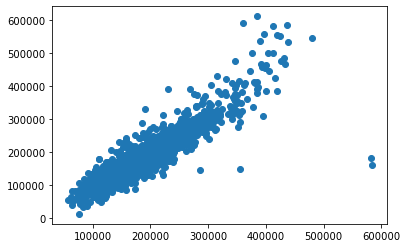

In [277]:
plt.scatter(x=preds, y = y_train)

(array([163., 601., 361., 235., 100.,  45.,  26.,   4.,   1.,   2.]),
 array([ 56682.98973706, 109421.15956352, 162159.32938999, 214897.49921646,
        267635.66904293, 320373.83886939, 373112.00869586, 425850.17852233,
        478588.3483488 , 531326.51817526, 584064.68800173]),
 <BarContainer object of 10 artists>)

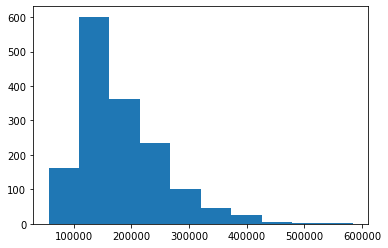

In [278]:
plt.hist(preds)

In [279]:
preds = lr.predict(X_test)

In [280]:
metrics.r2_score(y_test, preds)

0.8528771992887367

In [281]:
r2adj(lr, X_test, y_test)

0.849946466206839

In [282]:
metrics.mean_absolute_error(y_test, preds)

21895.68748422965

In [283]:
metrics.mean_squared_error(y_test, preds, squared=False)

30055.57576822912

In [284]:
metrics.mean_squared_error(y_test, preds)

903337634.7597613

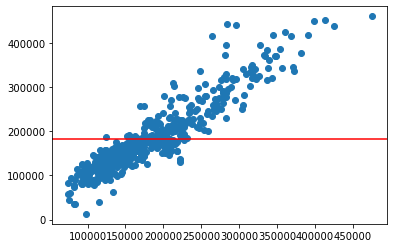

In [285]:
plt.scatter(preds, y_test)
plt.axhline(y_test.mean(), color='r')

(array([  5.,  37., 160., 141.,  72.,  39.,  24.,  15.,  10.,  10.]),
 array([ 12789. ,  57510.1, 102231.2, 146952.3, 191673.4, 236394.5,
        281115.6, 325836.7, 370557.8, 415278.9, 460000. ]),
 <BarContainer object of 10 artists>)

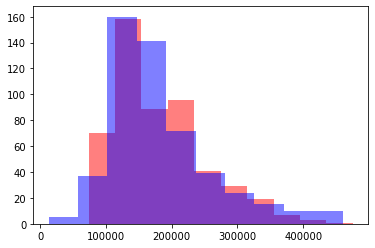

In [286]:
plt.hist(preds, color='r', alpha=.5)
plt.hist(y_test, color = 'blue', alpha=.5)

## KAGGLE SUBMISSION

## CREATION OF SEPARATE POLYNOMIAL FEATURES AND MODEL
Features ranging from 0.7-1.0

In [287]:
features = keylist7
X = poly2df[features]
y = poly2df['SalePrice']

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
X_train.head()

,Garage_Area 1st_Flr_SF,Kitchen_Qual^2,Exter_Qual,Exter_Qual^2,Exter_Qual Total_Bsmt_SF,Total_Bsmt_SF Bsmt_Qual,Exter_Qual 1st_Flr_SF,Gr_Liv_Area Garage_Area,Exter_Qual Bsmt_Qual,Kitchen_Qual Total_Bsmt_SF,...,Overall_Qual Bsmt_Qual,Overall_Qual Garage_Area,Gr_Liv_Area Bsmt_Qual,Exter_Qual Gr_Liv_Area,Gr_Liv_Area Kitchen_Qual,Overall_Qual Garage_Cars,Overall_Qual^2,Overall_Qual Kitchen_Qual,Overall_Qual Exter_Qual,Overall_Qual Gr_Liv_Area
532,833175.0,4.0,3.0,9.0,4761.0,4761.0,4761.0,833175.0,9.0,3174.0,...,18.0,3150.0,4761.0,4761.0,3174.0,12.0,36.0,12.0,18.0,9522.0
415,628476.0,4.0,3.0,9.0,3015.0,3015.0,3786.0,1128966.0,9.0,2010.0,...,21.0,3486.0,6801.0,6801.0,4534.0,14.0,49.0,14.0,21.0,15869.0
273,622080.0,9.0,3.0,9.0,2592.0,2592.0,2592.0,622080.0,9.0,2592.0,...,15.0,3600.0,2592.0,2592.0,2592.0,10.0,25.0,15.0,15.0,4320.0
1460,696098.0,9.0,4.0,16.0,5224.0,6530.0,5224.0,1204580.0,20.0,3918.0,...,35.0,3731.0,11300.0,9040.0,6780.0,14.0,49.0,21.0,28.0,15820.0
250,939501.0,9.0,4.0,16.0,4968.0,4968.0,5004.0,1878251.0,16.0,3726.0,...,32.0,6008.0,10004.0,10004.0,7503.0,24.0,64.0,24.0,32.0,20008.0


In [289]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [290]:
cross_val_score(lr, X_train, y_train).mean()

0.8432200727203674

In [291]:
cross_val_score(lr, X_test, y_test).mean()

0.8771033141355996

In [292]:
preds = lr.predict(X_train)

In [293]:
metrics.r2_score(preds, y_train)

0.8442777723234922

In [294]:
r2adj(lr, X_train, y_train)

0.8620282041597598

In [295]:
metrics.mean_absolute_error(y_train, preds)

19852.974396459926

In [296]:
metrics.mean_squared_error(y_train, preds)

852167030.371429

In [297]:
metrics.mean_squared_error(y_train, preds, squared=False)

29191.90008155394

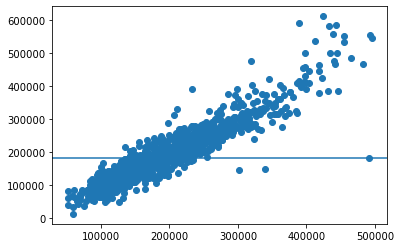

In [298]:
plt.scatter(preds, y_train)
plt.axhline(y_train.mean())

(array([ 34., 390., 620., 263., 129.,  51.,  28.,  10.,   6.,   7.]),
 array([ 13100. ,  72955.7, 132811.4, 192667.1, 252522.8, 312378.5,
        372234.2, 432089.9, 491945.6, 551801.3, 611657. ]),
 <BarContainer object of 10 artists>)

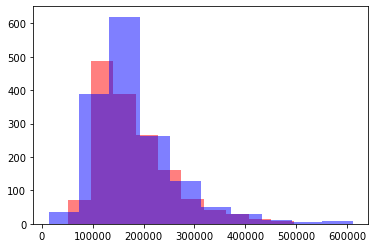

In [299]:
plt.hist(preds, color='r', alpha=.5)
plt.hist(y_train, color = 'blue', alpha=.5)

In [300]:
preds = lr.predict(X_test)

In [301]:
metrics.r2_score(preds, y_test)

0.8581122538978999

In [302]:
r2adj(lr, X_test, y_test)

0.8678265793166212

In [303]:
metrics.mean_absolute_error(y_test, preds)

19430.5812319146

In [304]:
metrics.mean_squared_error(y_test, preds)

754486097.8953315

In [305]:
metrics.mean_squared_error(y_test, preds, squared=False)

27467.910329971073

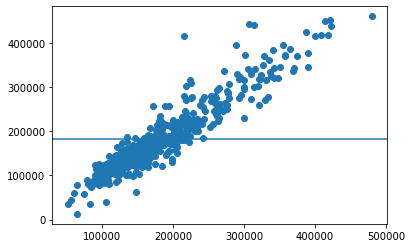

In [306]:
plt.scatter(preds, y_test)
plt.axhline(y_test.mean())

(array([  5.,  37., 160., 141.,  72.,  39.,  24.,  15.,  10.,  10.]),
 array([ 12789. ,  57510.1, 102231.2, 146952.3, 191673.4, 236394.5,
        281115.6, 325836.7, 370557.8, 415278.9, 460000. ]),
 <BarContainer object of 10 artists>)

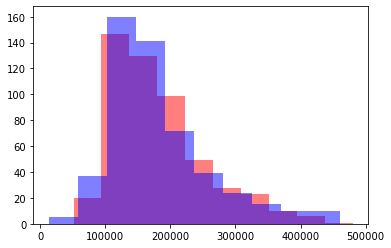

In [307]:
plt.hist(preds, color ='r', alpha=.5)
plt.hist(y_test, color='blue', alpha=.5)

### CREATION OF POLYNOMIALS FOR COLS BETWEEN 0.5-0.6

In [308]:
features = ['Year_Built', 'Garage_Finish', 'Year_Remod/Add', 'Fireplace_Qu','Full_Bath',
             'TotRms_AbvGrd', 'Mas_Vnr_Area']
X = traindice[features]
y = traindice['SalePrice']

In [309]:
poly = PolynomialFeatures(include_bias = False)
poly.fit(X)

PolynomialFeatures(include_bias=False)

In [310]:
X_poly = poly.transform(X)
X_poly

array([[1.9760e+03, 2.0000e+00, 2.0050e+03, ..., 3.6000e+01, 1.7340e+03,
        8.3521e+04],
       [1.9960e+03, 2.0000e+00, 1.9970e+03, ..., 6.4000e+01, 1.0560e+03,
        1.7424e+04],
       [1.9530e+03, 1.0000e+00, 2.0070e+03, ..., 2.5000e+01, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.9280e+03, 1.0000e+00, 1.9500e+03, ..., 8.1000e+01, 0.0000e+00,
        0.0000e+00],
       [1.9560e+03, 1.0000e+00, 1.9560e+03, ..., 3.6000e+01, 0.0000e+00,
        0.0000e+00],
       [1.9990e+03, 3.0000e+00, 1.9990e+03, ..., 4.9000e+01, 0.0000e+00,
        0.0000e+00]])

In [311]:
poly.get_feature_names(features)

['Year_Built',
 'Garage_Finish',
 'Year_Remod/Add',
 'Fireplace_Qu',
 'Full_Bath',
 'TotRms_AbvGrd',
 'Mas_Vnr_Area',
 'Year_Built^2',
 'Year_Built Garage_Finish',
 'Year_Built Year_Remod/Add',
 'Year_Built Fireplace_Qu',
 'Year_Built Full_Bath',
 'Year_Built TotRms_AbvGrd',
 'Year_Built Mas_Vnr_Area',
 'Garage_Finish^2',
 'Garage_Finish Year_Remod/Add',
 'Garage_Finish Fireplace_Qu',
 'Garage_Finish Full_Bath',
 'Garage_Finish TotRms_AbvGrd',
 'Garage_Finish Mas_Vnr_Area',
 'Year_Remod/Add^2',
 'Year_Remod/Add Fireplace_Qu',
 'Year_Remod/Add Full_Bath',
 'Year_Remod/Add TotRms_AbvGrd',
 'Year_Remod/Add Mas_Vnr_Area',
 'Fireplace_Qu^2',
 'Fireplace_Qu Full_Bath',
 'Fireplace_Qu TotRms_AbvGrd',
 'Fireplace_Qu Mas_Vnr_Area',
 'Full_Bath^2',
 'Full_Bath TotRms_AbvGrd',
 'Full_Bath Mas_Vnr_Area',
 'TotRms_AbvGrd^2',
 'TotRms_AbvGrd Mas_Vnr_Area',
 'Mas_Vnr_Area^2']

In [312]:
poly3df = pd.DataFrame(X_poly, columns = poly.get_feature_names(features))
poly3df

,Year_Built,Garage_Finish,Year_Remod/Add,Fireplace_Qu,Full_Bath,TotRms_AbvGrd,Mas_Vnr_Area,Year_Built^2,Year_Built Garage_Finish,Year_Built Year_Remod/Add,...,Fireplace_Qu^2,Fireplace_Qu Full_Bath,Fireplace_Qu TotRms_AbvGrd,Fireplace_Qu Mas_Vnr_Area,Full_Bath^2,Full_Bath TotRms_AbvGrd,Full_Bath Mas_Vnr_Area,TotRms_AbvGrd^2,TotRms_AbvGrd Mas_Vnr_Area,Mas_Vnr_Area^2
0,1976.0,2.0,2005.0,0.0,2.0,6.0,289.0,3904576.0,3952.0,3961880.0,...,0.0,0.0,0.0,0.0,4.0,12.0,578.0,36.0,1734.0,83521.0
1,1996.0,2.0,1997.0,3.0,2.0,8.0,132.0,3984016.0,3992.0,3986012.0,...,9.0,6.0,24.0,396.0,4.0,16.0,264.0,64.0,1056.0,17424.0
2,1953.0,1.0,2007.0,0.0,1.0,5.0,0.0,3814209.0,1953.0,3919671.0,...,0.0,0.0,0.0,0.0,1.0,5.0,0.0,25.0,0.0,0.0
3,2006.0,3.0,2007.0,0.0,2.0,7.0,0.0,4024036.0,6018.0,4026042.0,...,0.0,0.0,0.0,0.0,4.0,14.0,0.0,49.0,0.0,0.0
4,1900.0,1.0,1993.0,0.0,2.0,6.0,0.0,3610000.0,1900.0,3786700.0,...,0.0,0.0,0.0,0.0,4.0,12.0,0.0,36.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2007.0,3.0,2007.0,4.0,2.0,7.0,0.0,4028049.0,6021.0,4028049.0,...,16.0,8.0,28.0,0.0,4.0,14.0,0.0,49.0,0.0,0.0
2047,1940.0,1.0,1950.0,0.0,1.0,4.0,0.0,3763600.0,1940.0,3783000.0,...,0.0,0.0,0.0,0.0,1.0,4.0,0.0,16.0,0.0,0.0
2048,1928.0,1.0,1950.0,3.0,1.0,9.0,0.0,3717184.0,1928.0,3759600.0,...,9.0,3.0,27.0,0.0,1.0,9.0,0.0,81.0,0.0,0.0
2049,1956.0,1.0,1956.0,4.0,1.0,6.0,0.0,3825936.0,1956.0,3825936.0,...,16.0,4.0,24.0,0.0,1.0,6.0,0.0,36.0,0.0,0.0


In [313]:
poly3df['SalePrice'] = traindice['SalePrice']

poly3corr = poly3df.corr()[['SalePrice']].sort_values('SalePrice').iloc[:-1, :]
poly3corr

,SalePrice
Mas_Vnr_Area^2,0.381692
TotRms_AbvGrd^2,0.490617
Mas_Vnr_Area,0.503579
TotRms_AbvGrd,0.504014
Year_Remod/Add Mas_Vnr_Area,0.507068
Year_Built Mas_Vnr_Area,0.507377
Year_Remod/Add TotRms_AbvGrd,0.524402
Full_Bath^2,0.533664
Year_Built TotRms_AbvGrd,0.537303
Garage_Finish^2,0.537432


### Third Feature Setting
Using features from original training dataframe with coefficients ranging from 0.3-1.0

In [314]:
features = ['Overall_Qual', 'Exter_Qual', 'Gr_Liv_Area', 'Kitchen_Qual', 'Garage_Area', 'Garage_Cars',
           'Total_Bsmt_SF', '1st_Flr_SF', 'Bsmt_Qual', 'Year_Built', 'Garage_Finish', 'Year_Remod/Add', 'Fireplace_Qu',
           'Full_Bath', 'TotRms_AbvGrd', 'Mas_Vnr_Area', 'Wood_Deck_SF', 'Open_Porch_SF', 'Lot_Frontage', 
            'BsmtFin_SF_1', 'Fireplaces']
X = traindice[features]
y = traindice['SalePrice']

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
X_train.head()

,Overall_Qual,Exter_Qual,Gr_Liv_Area,Kitchen_Qual,Garage_Area,Garage_Cars,Total_Bsmt_SF,1st_Flr_SF,Bsmt_Qual,Year_Built,...,Year_Remod/Add,Fireplace_Qu,Full_Bath,TotRms_AbvGrd,Mas_Vnr_Area,Wood_Deck_SF,Open_Porch_SF,Lot_Frontage,BsmtFin_SF_1,Fireplaces
532,6,3,1587,2,525.0,2.0,1587.0,1587,3,1971,...,1971,4,2,7,302.0,0,44,85.0,838.0,1
415,7,3,2267,2,498.0,2.0,1005.0,1262,3,1937,...,1980,4,1,7,0.0,521,0,107.0,288.0,2
273,5,3,864,3,720.0,2.0,864.0,864,3,1950,...,2002,0,1,5,0.0,194,0,60.0,398.0,0
1460,7,4,2260,3,533.0,2.0,1306.0,1306,5,1996,...,1997,0,2,7,0.0,296,44,80.0,1201.0,0
250,8,4,2501,3,751.0,3.0,1242.0,1251,4,1995,...,1995,3,2,9,466.0,192,87,0.0,0.0,1


In [316]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [317]:
lr.score(X_train, y_train)

0.8143456479151828

In [318]:
lr.score(X_test, y_test)

0.871843004710855

In [319]:
cross_val_score(lr, X_train, y_train)

array([0.84219032, 0.83028979, 0.83414378, 0.78828944, 0.608362  ])

In [320]:
cross_val_score(lr, X_train, y_train).mean()

0.780655066744433

In [321]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)

DummyRegressor()

In [322]:
dummy.score(X_train, y_train)

0.0

In [323]:
dummy.score(X_test, y_test)

-0.00043273813883448753

In [324]:
cross_val_score(dummy, X_train, y_train).mean()

-0.0009377481689546663

In [325]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [326]:
tree.score(X_train, y_train)

0.9999999814950216

In [327]:
tree.score(X_test, y_test)

0.7952750477299381

In [328]:
cross_val_score(tree, X_train, y_train).mean()

0.7128150881045509